In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

# Sampling random points in the 2D space

In [10]:
n_samples=500
sampled_x_raw = np.random.random(n_samples)*-10 + 2.5
sampled_y_raw = np.random.random(n_samples)*-10 + 2.5

In [11]:
# min and max of the sampled ponints in x and y will be used to put the bspline grid
# in a way that it covers the points and have an extra lower bound and an extra upper bound 
# control points
x_min = np.amin(sampled_x_raw)
x_max = np.amax(sampled_x_raw)
y_min = np.amin(sampled_y_raw)
y_max = np.amax(sampled_y_raw)

## calculating control points positions wrt samples 

In [12]:
grid = (3,4)
# x_min - 1 is to make sure the sampled points be inside the grid,
# perhaps a better way instead of subtracting/adding 1 can be to subtract/add the x_spacing, y_spacing
c_points_x,delta_x = np.linspace(x_min - 1,x_max + 1, grid[0],retstep=True)
c_points_y,delta_y = np.linspace(y_min - 1,y_max + 1, grid[1], retstep=True)
# adding the extra lower and upper bound points 
c_points_x = np.insert(c_points_x,0, c_points_x[0]-delta_x)
c_points_x = np.append(c_points_x,c_points_x[-1]+delta_x)
#
c_points_y = np.insert(c_points_y,0, c_points_y[0]-delta_y)
c_points_y = np.append(c_points_y,c_points_y[-1]+delta_y)


In [13]:
cpoints_grid_X,cpoints_grid_Y = np.meshgrid(c_points_x,c_points_y,indexing='ij')

In [14]:
def get_alpha_beta(x_y):
    """
    x_y: x,y coordinate in the 2D space
    return: the alpha and beta 
    """
    return x_y[0]/delta_x - np.floor(x_y[0]/delta_x), x_y[1]/delta_y - np.floor(x_y[1]/delta_y)

def get_i_j(x_y):
    """
    x_y: x,y coordinate in the 2D space
    return: i and j index
    """
    return int(np.floor(x_y[0]/delta_x) - 1), int(np.floor(x_y[1]/delta_y) - 1)
  
    
def bspline_eval(k,t):
    if k==0:
        return (t * (t * (-t + 3) - 3) + 1) / 6
    elif k==1:
        return (t * t * (3 * t - 6) + 4) / 6
    elif k==2:
        return (t * (t * (-3 * t + 3) + 3) + 1) / 6
    elif k==3:
        return t * t * t / 6

Text(0, 0.5, 'y')

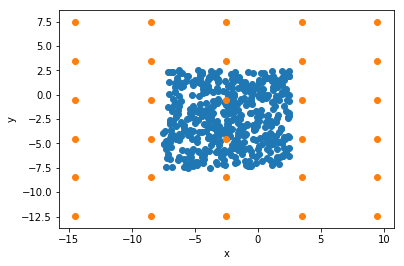

In [19]:
plt.scatter(sampled_x_raw,sampled_y_raw,label='samples')
plt.scatter(cpoints_grid_X,cpoints_grid_Y, label = 'bspline control points')
plt.xlabel('x')
plt.ylabel('y')
# plt.legend()

In [20]:
# translating the whole points so that the first control point sits at 0,0
first_cpoint = (cpoints_grid_X[0,0],cpoints_grid_Y[0,0])
X = cpoints_grid_X-first_cpoint[0]
Y = cpoints_grid_Y-first_cpoint[1]
sampled_x = sampled_x_raw-first_cpoint[0]
sampled_y = sampled_y_raw-first_cpoint[1]

i,j (0, 0)
alpha,beta (0.6687646041332529, 0.25163723073758715)


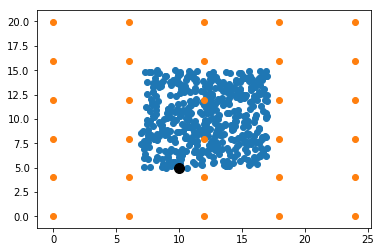

In [30]:
# plot to diagnose the get_i_j and get_alpha_beta
x=10
y=5
plt.scatter(sampled_x,sampled_y)
plt.scatter(X,Y)
plt.scatter(x,y,s=100,c='k')
print("i,j",get_i_j((x,y)))
print("alpha,beta",get_alpha_beta((x,y)))

In [31]:
# value at each sample, so the true solution would be the value at each control point to be 10 too
u_x = np.ones_like(sampled_x)*10

In [32]:
sampled_x_y = np.stack((sampled_x,sampled_y)).T
all_i_j = np.apply_along_axis(get_i_j,arr=sampled_x_y,axis=1)
all_alpha_beta = np.apply_along_axis(get_alpha_beta,arr=sampled_x_y,axis=1)

In [33]:
B_matrix = np.zeros((u_x.shape[0],len(X.flatten())))
for n in range(u_x.shape[0]):
    for l in range(4):
        for m in range(4):
            ij = all_i_j[n,:]
            alpha_beta = all_alpha_beta[n,:]
            b_l = bspline_eval(l,alpha_beta[0])
            b_m = bspline_eval(m,alpha_beta[1])
            b = b_l*b_m
            current_p_index = ij + np.array((l,m))
            B_matrix[n,np.ravel_multi_index(current_p_index, X.shape)]=b
            
B_matrix_transposed = np.matrix.transpose(B_matrix)
BB = np.matmul(np.linalg.inv(np.matmul(B_matrix_transposed,B_matrix)),B_matrix_transposed)
p = np.matmul(BB,u_x)
p_reshaped = np.reshape(p,X.shape)


In [35]:
p_reshaped

array([[ 9.99999966, 10.00000003,  9.99999999, 10.00000001,  9.99999997,
        10.00000032],
       [10.00000003, 10.        , 10.        , 10.        , 10.        ,
         9.99999998],
       [10.        , 10.        , 10.        , 10.        , 10.        ,
        10.        ],
       [10.        , 10.        , 10.        , 10.        , 10.        ,
        10.        ],
       [10.00000001, 10.        , 10.        , 10.        , 10.        ,
         9.99999999]])

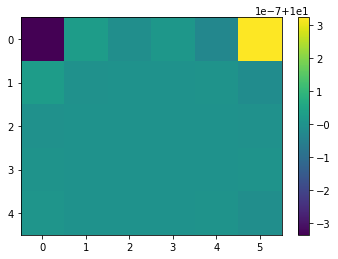

In [34]:
plt.imshow(np.reshape(p,X.shape))
plt.colorbar()

In [36]:
error = 0
error_grid = np.empty(X.shape)
for n in range(u_x.shape[0]):
    result = 0
    for l in range(4):
        for m in range(4):
            ij = all_i_j[n,:]
            alpha_beta = all_alpha_beta[n,:]
            current_p_index = ij + np.array((l,m))
            b_l = bspline_eval(l,alpha_beta[0])
            b_m = bspline_eval(m,alpha_beta[1])
            bb = b_l*b_m
            current_p_index = ij + np.array((l,m))
            result += bb*p_reshaped[tuple(current_p_index)]
    error += np.abs(u_x[n]-result)
#     print(np.abs(u_x[n]-result))

In [37]:
error/n_samples

1.757204159957837e-11